In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import sys
from time import sleep
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import plotly.graph_objects as go 


In [2]:
users = pd.read_parquet('../data/processed/users.parquet.gzip')

In [3]:
users.head()

,id,photo,sex,city,country,likes,weighted_age
0,11946,https://sun6-22.userapi.com/s/v1/ig2/KGV4KtNi0...,1,Санкт-Петербург,Россия,8,35
1,62102,https://sun6-21.userapi.com/s/v1/ig2/iu0M-ERxn...,1,Москва,Россия,9,35
2,662418,https://sun6-21.userapi.com/s/v1/if2/gxSDA6_Q6...,2,Hong Kong,Китай,16,35
3,1277906,https://sun6-23.userapi.com/s/v1/if1/yzq3SNC64...,1,Москва,Россия,10,34
4,1345035,https://sun6-21.userapi.com/s/v1/if1/1xpNC-mZ-...,1,Москва,Россия,17,35


In [4]:
users.shape

(67491, 7)

In [5]:
females = users.query('sex == 1').groupby('weighted_age').count()['id']
males = users.query('sex == 2').groupby('weighted_age').count()['id']
age_data = pd.DataFrame({'age':males.index, 'male':males.values, 'female':females.values})
age_data = age_data.set_index('age')

In [6]:
last_10_male = age_data['male'][-10:].sum()
last_10_female = age_data['female'][-10:].sum()

predlast_10_male = age_data['male'][-20:-10].sum()
predlast_10_female = age_data['female'][-20:-10].sum()

first_3_male = age_data['male'][:3].sum()
first_3_female = age_data['female'][:3].sum()

In [7]:
age_data = age_data.drop(range(25,45))
age_data = age_data.drop(range(14,17))

In [8]:
age_data.loc['14-16'] = {'male':first_3_male, 'female':first_3_female}
age_data.loc['25-34'] = {'male':predlast_10_male, 'female':predlast_10_female}
age_data.loc['35-44'] = {'male':last_10_male, 'female':last_10_female}

In [9]:
age_data = age_data.reset_index()
age_data.age = age_data.age.apply(str)
age_data = age_data.sort_values('age').reset_index(drop=True)

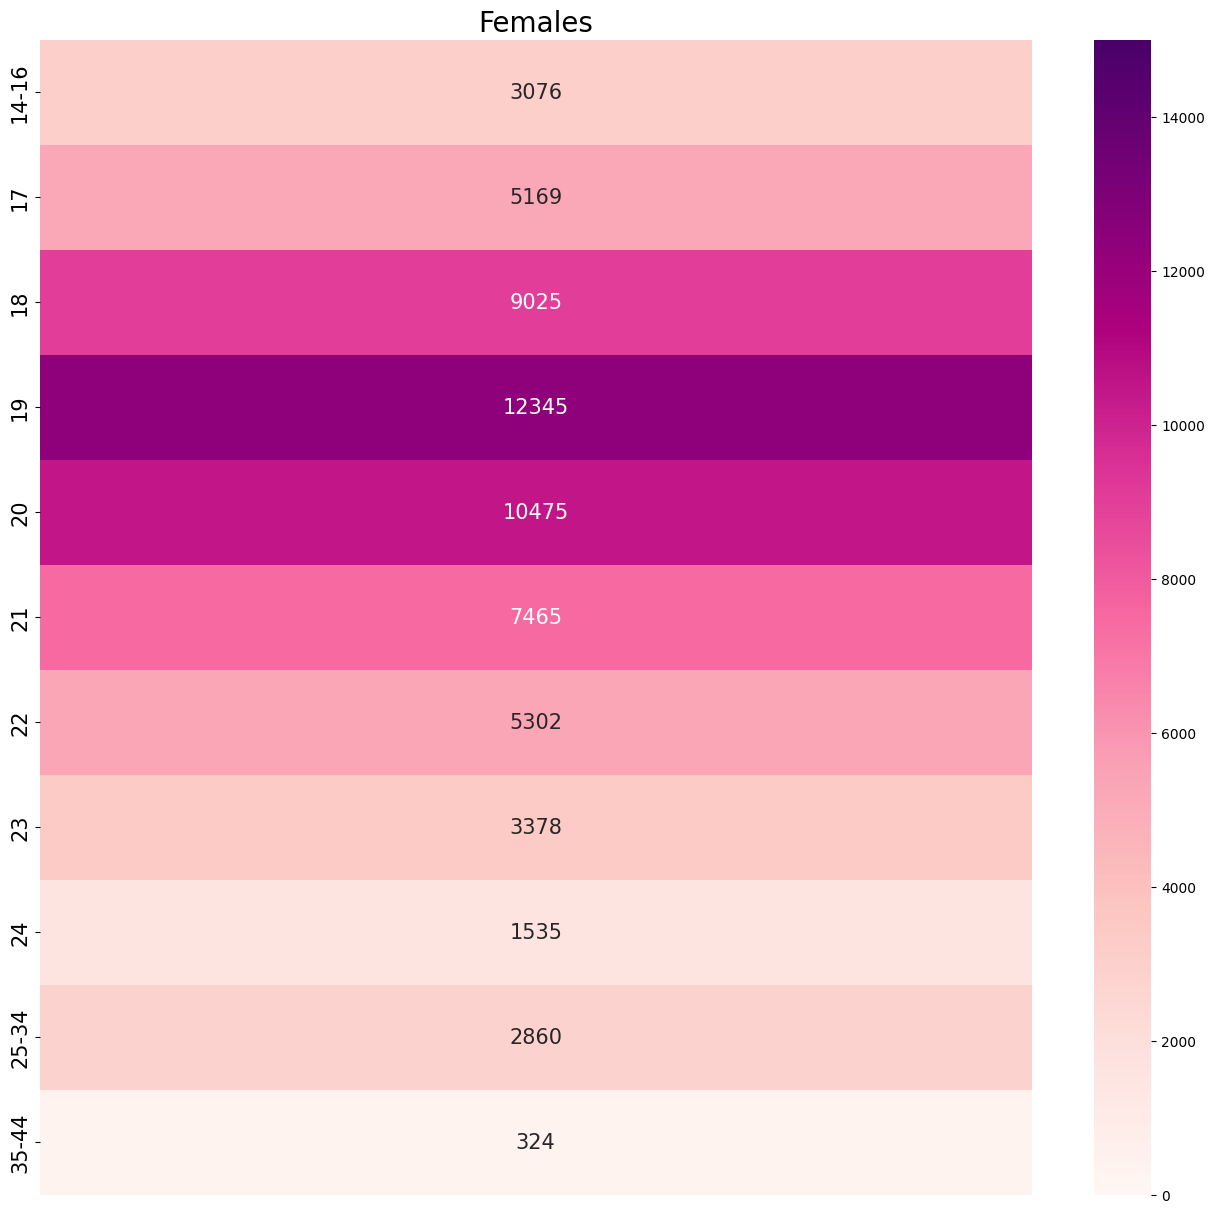

In [10]:
plt.gcf().set_size_inches(16, 15)

# Create heatmap
sns.heatmap(age_data.female.values.reshape(11,1), 
            cmap='RdPu',     # Sequential colorscale
            annot=True,        # Show values
            annot_kws={"fontsize": 15,
                       #"weight": 'bold'
                      },
            vmin=0, vmax=15000,
            fmt='.0f',         # Integer format
            xticklabels=False,  
            yticklabels=age_data.age.values)  
plt.title('Females', fontsize=20)
plt.yticks(fontsize=15)
plt.savefig('../reports/figures/females_age.png')

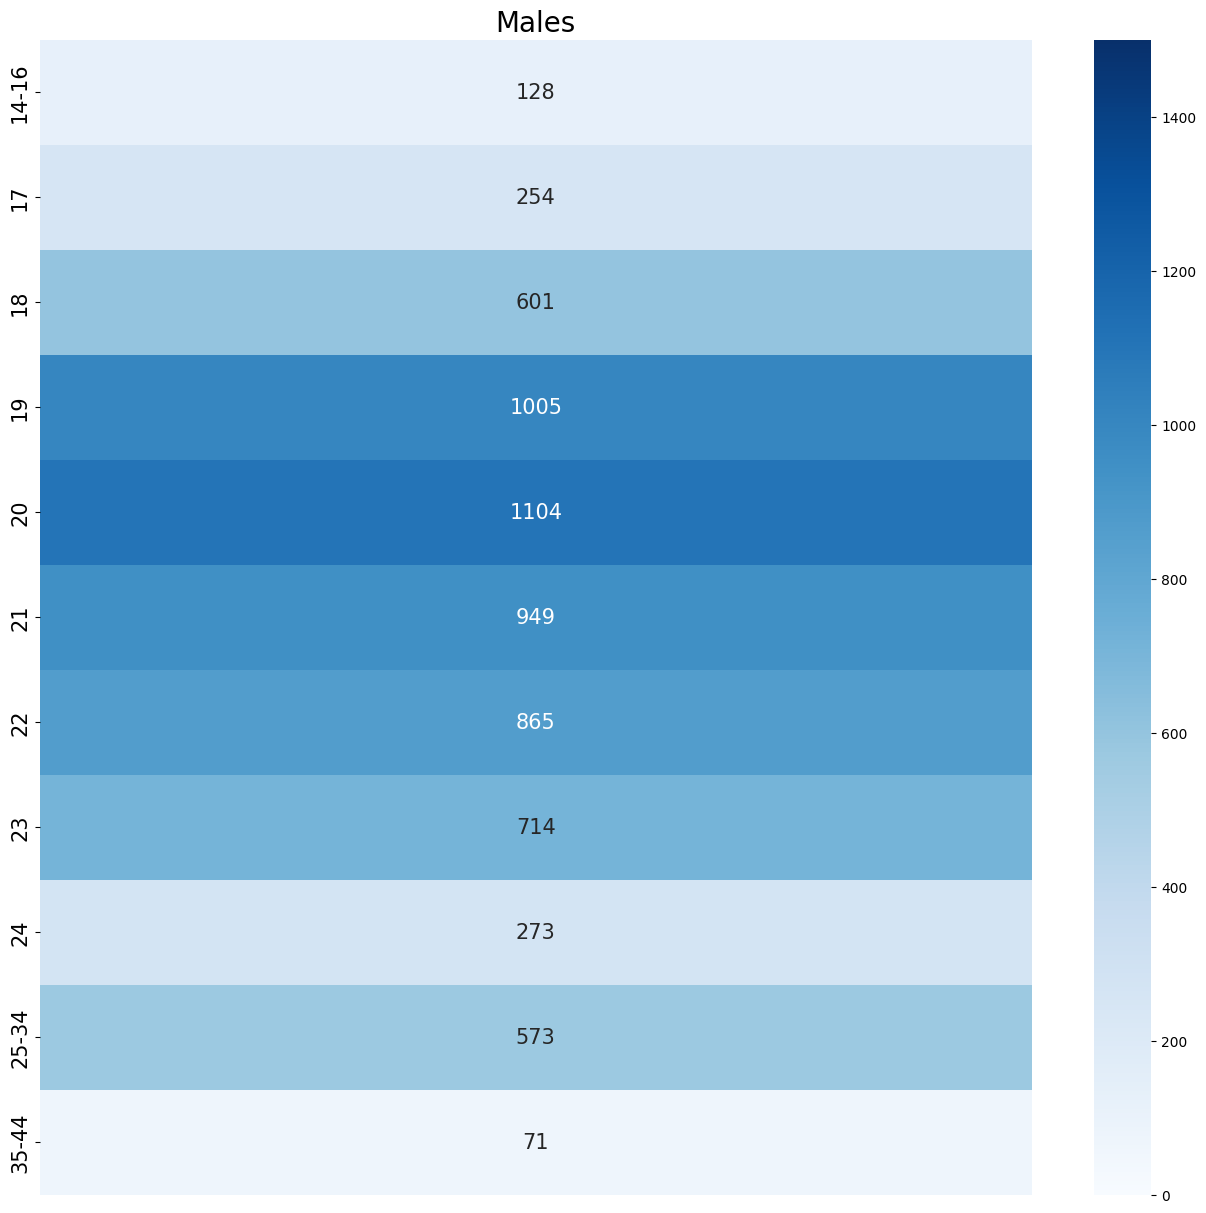

In [11]:
plt.gcf().set_size_inches(16, 15)

# Create heatmap
sns.heatmap(age_data.male.values.reshape(11,1), 
            cmap='Blues',     # Sequential colorscale
            annot=True,        # Show values
            annot_kws={"fontsize": 15,
                       #"weight": 'bold'
                      },
            vmin=0, vmax=1500,
            fmt='.0f',         # Integer format
            xticklabels=False,  
            yticklabels=age_data.age.values)  
plt.title('Males', fontsize=20)
plt.yticks(fontsize=15)
plt.savefig('../reports/figures/males_age.png')

In [12]:
c = Counter(users[~users.country.isna()].country.values)
countries = dict(c.most_common(10))
k = countries.keys()
v = countries.values()

countries = {'countries':list(k),
             'values': list(v)
            }

In [13]:
colors = ['#1f77b4',  '#ff7f0e',  '#2ca02c', '#d62728', '#9467bd', 
         '#8c564b', '#e377c2', '#ffc300', '#bcbd22','#17becf',   
         '#339966','#ff6686', '#f5b8ec', '#bb77dd', '#77ddca']

fig = go.Figure(data=[go.Bar(x=countries['countries'], y=countries['values'], 
                             marker_color=colors,
                             marker_opacity=0.7,
                             width=0.75
                             )])
fig.update_layout(
    barmode="stack",
    title=dict(
        text="Dataset' national composition",
        font=dict(size=30)
    ),
    xaxis_title=dict(
        text="Country",
        font=dict(size=22)
    ),
    yaxis_title=dict(
        text="People",
        font=dict(size=22)
    ),
    #width=1400,
    height=1000,
    yaxis_type="log", 
    yaxis_tickmode="array", 
    yaxis_tickvals=[0, 100, 400, 1000, 2500, 5000, 10000, 40000],
    plot_bgcolor='rgb(255,255,255)', # White plot background
    xaxis = dict(
        tickfont = dict(
            size = 20  # Set x-axis tick font size to 20px
        )
    ),
    yaxis = dict(
        tickfont = dict(
            size = 20  # Set x-axis tick font size to 20px
        )
    )
    
)
fig.show()

In [16]:
cities_all = users[~users.city.isna()].city.values

c = Counter(cities_all)
cities_data = dict(c.most_common(14))

# Create figure 
fig = go.Figure()

city_locations = {
  'Moscow': (55.7558, 37.6173),     
  'Saint-Petersburg': (59.9392, 30.3141), 
  'Ekaterinburg': (56.8389, 60.5972),
  'Novosibirsk': (55.0167, 82.9333),   
  'Krasnodar': (45.0354, 38.9720),    
  'Chelyabinsk': (55.1540, 61.4260),   
  'Rostov-on-Don': (47.2314, 39.7247),  
  'Nizhny Novgorod': (56.3269, 44.0063),
  'Krasnoyarsk': (56.0183, 92.8667),     
  'Samara': (53.1958, 50.1521),    
  'Perm': (58.0102, 56.2544),        
  'Voronezh': (51.6719, 39.2002),         
  'Omsk': (55.0041, 73.4208),    
  'Kazan': (55.7922, 49.1054) 
}

colors = [
    '#ff0000',  # Red
    '#ff9900',  # Orange
    '#ffff00',  # Yellow
    '#00ff00',  # Green
    '#00ffff',  # Cyan
    '#0000ff',  # Blue
    '#9900ff',  # Violet
    '#ff00ff',  # Magenta
    '#ff9966',   # Salmon
    '#9966ff',    # Blue violet
    '#66ff99',   # Spring green
    '#ffcc99' ,  # Peach
    '#ff9999' ,  # Rose
    '#ff6600'     # Vermillion  
]

# Add map 
fig.add_trace(go.Scattermapbox(
    lat=np.array(list(city_locations.values()))[:,0], 
    lon=np.array(list(city_locations.values()))[:,1],
    mode='markers+text',
    marker=go.scattermapbox.Marker(
        size=np.array(list(cities_data.values()))/40,
        color=colors,
        opacity=0.4
    ),
    hovertext=list(cities_data.values()),  # City names
))

fig.update_traces(textposition='top center') 

# Add layout
fig.update_layout(
    title='Number of people by cities in Russia',
    width=1600,
    height=800,
    mapbox_style="open-street-map",
    mapbox_zoom=3.9, 
    mapbox_center = {"lat": 55, "lon": 62}
)

# Display figure
fig.show()

# Fixing items: reducing posts likers according to the users dataset

In [ ]:
items = pd.read_parquet('../data/interim/items_all_likers.parquet.gzip')

users_ids = list(users.id.values)

def filter_row(row):
    # remain only users that are in users dataset
    mask = np.isin(row, users_ids)
    return row[mask]

items_filtered = items.likers.progress_apply(filter_row)
items.likers = items_filtered
items.likes = items.likers.apply(len).values

items.to_parquet('../data/processed/items.parquet.gzip', compression='gzip')